# Make Obs Movie Plots
## Make slice plots (for movie) of dye observations
This notebook is revised (5/2020) with improved projection methods for the cross-front coordinate.


In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 11 15:24:57 2019

@author: jacob
"""

import h5py
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np
from cmocean import cm as cmo
from scipy.interpolate import griddata
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy.ma as ma
from shapely.geometry import LineString

#from matplotlib.mlab import griddata
import datetime as dt
import gsw
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
#%%
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

In [2]:
#%% LOAD MET DATA

filename = '/data/pacific/jacob/LATMIXDYE/LATMIX/LES_COARE35_forcing.mat' # Front run
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
# List all groups
yearday = matfile['yearday']
tau_cs = matfile['tau_cs']
tau_d = matfile['tau_d']
qnet = matfile['net_heat_flux']
tmag = np.sqrt(tau_cs**2 + tau_d**2)


#%% LOAD SST MAP

filename = '/data/pacific/jacob/LATMIXDYE/SatData/AVHRR493data.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)

sstdatafile=matfile['sstdata']

temp0 = sstdatafile[0]
temp1 = sstdatafile[1]
temp2 = sstdatafile[2]

sstdata = temp0.sst
sst=(sstdata.bytes-0.5)*sstdata.scale; 
sst[sst<0] = np.nan; 
sst=sst+sstdata.min

latgrid = temp0.subset.latgrid
longrid = temp0.subset.lonEgrid

latlimr = np.argmin(np.abs(latgrid-38))
latliml = np.argmin(np.abs(latgrid-40))
lonliml = np.argmin(np.abs(longrid+66))
lonlimr = np.argmin(np.abs(longrid+62))

#%% LOAD DYE DATA (GRIDDED IN DEPTH BY M. SUNDERMEYER)

filename = '/data/pacific/jacob/LATMIXDYE/LatMix_2012_Transfer/my_triaxus_SI2'
matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)

latK = matfile['lat_ts']
lonK = matfile['lon_ts']

depth = matfile['DEPTH']
fluorppb = matfile['FLUORPPB']
shiplog = matfile['SHIPLOG']
rho = matfile['PDENS']
jday = matfile['JDAY']
lat = matfile['LAT']
lon = matfile['LON']
II = matfile['II'] # This indexes individual gulf stream crossings

fluorppb[np.isnan(fluorppb)] = 0
fluorppb[fluorppb<0] = 0
fluorppb[fluorppb==0] = 1e-10
nd, ns = shiplog.shape

#%% LOAD TIMESERIES DATA (UNGRIDDED)

jday_ts = matfile['jday_ts']
fluorppb_ts = matfile['fluorPPB_ts']
depth_ts = matfile['depth_ts']
lat_ts = matfile['lat_ts']
lon_ts = matfile['lon_ts']
rho_ts = matfile['pdens_ts']
T_ts = matfile['T_ts']
S_ts = matfile['S_ts']
ii = matfile['ii'] # This indexes individual gulf stream crossings

#%% LOAD FLOAT DATA
filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Mar05_SI_2_Track.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
floatstruct = matfile['F']
flat = floatstruct.lat
flon = floatstruct.lon
fyd = floatstruct.yd-1 #Craig convention

fyds = floatstruct.yds - 1
flats = floatstruct.lats
flons = floatstruct.lons


#fvellat = np.gradient(flats)/np.gradient(fyds*86400)
#fvellon = np.gradient(flons)/ np.gradient(fyds*86400)
#fdir = np.arctan2(fvellat, fvellon)

filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Env.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
fT = matfile['T']
fS = matfile['S']
fT = np.mean(fT, axis=-1)# Top and bottom sensors
fS = np.mean(fS, axis=-1)
fydr = matfile['yd'] - 1
fP = matfile['P']

In [3]:
# Projection routine for taking a lat, lon coordinate, and projecting it into the coordinate normal to the float direction
# By default this uses epsg:26920 (zone 20 UTM), but can also send other projections
# Naive projection is just to directly convert to meters (projection='naive')

import pyproj as proj

def projection(x,y,theta): #x, y, are ship track, theta is the direction of the float velocity
    on = np.array([np.cos(theta), np.sin(theta)]) # unit vector of direction
    pj = (np.dot(np.array([x,y]).T, on)*on[:,np.newaxis])
    return pj

def rejection(x,y,theta): # orthogonal component of ships track
    pj = projection(x,y,theta)
    return np.array([x,y]) - pj

def projecDims(x,y,mfx, mfy, theta): #returns the distance in the float-normal, with 0=float location
    on = np.array([np.cos(theta), np.sin(theta)]) #unit vector of float DIRECTION (diff from position)
    pj = projection(x,y, theta) #get portion of ship track in direction of float travel
    rj = rejection(x,y,theta) # get portion of ship track in direction normal to float travel
    fj = rejection(np.array([mfx]),np.array([mfy]), theta) # get portion of float-ship intersection normal to float travel
    
    distrej = np.dot(rj.T, np.array([-np.sin(theta), np.cos(theta)])) #get the distance of the ship track normal to float dir
    distfloat = np.dot(fj.T, np.array([-np.sin(theta), np.cos(theta)])) #get the distance of float-ship intersection normal to float dir
    return distrej-distfloat # return the difference between the two (this centers y=0 as the position of the float-ship intersection)

#Call to convert lat-lon to float orthogonal coordinate system, returns ortho distance 
# projection defines the type of projection from lat-lon -> local is most locally accurate
def projectCoords(lat, lon, flat, flon, ftime, projection='epsg:26920'):
    print(f"Projection type: {projection}")
    if projection == 'naive': # Directly convert to meters
        y = (lat)*111e3 
        x = (lon*np.cos(lat*np.pi/180))*111e3
        fy = flat*111e3
        fx = flon*111e3*np.cos(flat*np.pi/180)
    elif projection=='local':
        crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic
        #Erect own local flat cartesian coordinate system around mean lat/lon
        cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(np.nanmean(lat), np.nanmean(lon)))
        x, y = proj.transform(crs_wgs, cust, lon, lat)
        fx, fy = proj.transform(crs_wgs, cust, flon, flat)
    else: # Use a UTM projection
        transformer = proj.Transformer.from_crs('epsg:4326', projection, always_xy=True)
        x, y = transformer.transform(lon, lat)
        fx, fy = transformer.transform(flon, flat)
        
    # The triaxus trails the ship (which is where the lat/lon points are). 
    # Craig estimates that for this deployment the offset to the ship is ~800m.
    # For the purpose of plotting we use 800 m offset opposite the ships direction of travel.
    # Note that this does not affect the quantitative calculations (ie. 2nd moment)
    angship = np.arctan2(np.gradient(y, axis=-1), np.gradient(x, axis=-1)) # angle of ship travel
    triaxus_off = 800 # distance in meters the triaxus trails the ship
    x = x - triaxus_off*np.cos(angship) # shift the position to triaxus location
    y = y - triaxus_off*np.sin(angship)
    # Here we calculate the float direction of travel
    fxv = np.gradient(fx)/np.gradient(ftime*86400) # Calculate float velocity
    fyv = np.gradient(fy)/np.gradient(ftime*86400)
    #fxvm = (np.interp(np.nanmean(jday[:,span]), ftime, fxv)) # Interpolate float velocity to the mean section time
    #fyvm = (np.interp(np.nanmean(jday[:,span]), ftime, fyv))
    fxvm = np.mean(np.interp(jday_ts[span_ts], ftime, fxv))
    fyvm = np.mean(np.interp(jday_ts[span_ts], ftime, fyv))
    theta = np.arctan2(fyvm, fxvm) # Get the angle of the mean float velocity


    #meanfloaty = np.interp(np.nanmean(jday[:,span]), ftime, fy) # What is the float lat during the survey average?
    #meanfloatx = np.interp(np.nanmean(jday[:,span]), ftime, fx) # What is the float lon during the survey average?
    #print(meanfloatx); print(meanfloaty)
    
    
    #xi = x.ravel()
    #yi = y.ravel()
    #m = np.isfinite(xi+yi) 
    #fxi = np.interp(jday[:,span].ravel(), fyds, fx)
    #fyi = np.interp(jday[:,span].ravel(), fyds, fy)
    #cx = np.nanargmin((fxi-xi)**2+(fyi-yi)**2)

    #xf = np.linspace(-1e5, 1e5)*np.cos(theta) + meanfloatx 
    #yf = np.linspace(-1e5, 1e5)*np.sin(theta) + meanfloaty
    
    # Float positions are less frequently sampled, interpolate them to the triaxus times
    xf = np.interp(np.nanmean(jday[:,span], axis=0), ftime, fx)
    yf = np.interp(np.nanmean(jday[:,span], axis=0), ftime, fy)
    # Here we look for the intersection of the ship track and float track, and treat that as y=0.
    xs = np.nanmean(x, axis=0)
    ys = np.nanmean(y, axis=0)
    first_line = LineString(np.column_stack((xs, ys)))
    second_line = LineString(np.column_stack((xf, yf)))
    intersection = first_line.intersection(second_line)
    meanfloatx = intersection.xy[0][-1]
    meanfloaty = intersection.xy[1][-1]
    
    # Rotate coordinate system into along-float direction (x), and across-float direction (y)
    #rotatedpoints = (x*np.cos(theta)+y*np.sin(theta), -x*np.sin(theta)+y*np.cos(theta))

    #ang = np.arctan2(y, x)
    #angdiff = ang-theta
    #offsetlength = np.sqrt(meanfloatx**2+meanfloaty**2)*np.cos(angdiff)
    #offsetx = offsetlength*np.cos(ang); offsety = offsetlength*np.sin(ang)
    #rotatedoff = (offsetx*np.cos(theta)+offsety*np.sin(theta), -offsetx*np.sin(theta)+offsety*np.cos(theta))
    #rx = rotatedpoints[0] - rotatedoff[0]; ry = rotatedpoints[1]-rotatedoff[1]

    ns = x.shape[-1]
    ry = np.zeros(x.shape)
    for i in range(0, ns):
        ry[:,i] = projecDims(x[:,i],y[:,i],meanfloatx, meanfloaty, theta)
    
    return 0*ry/1000, ry/1000


In [6]:
# Project a section by crossing number into the float-normal coordinate system and interpolate to uniform grid

def getProjectedSection(crossing):
    span = range(II[crossing,0], II[crossing,1])
    span_ts = range(ii[crossing,0], ii[crossing,1])

    values = fluorppb[:,span]
    values[values<=0] = 1e-10 # Put a small value for plotting the log_10 values
    values = values/np.nanmax(fluorppb) # Normalize by the maximum observed concentration
    # Project to float normal coordinate system
    rx, shiplogc = projectCoords(lat[:,span], lon[:,span], floatstruct.lats, floatstruct.lons, fyds, projection='local')

    # Interpolate the data
    grid_x = np.linspace(-6, 6, 12*4) # Choose the cross-float gridding
    grid_y = depth[:,1] # Here we are using the gridded data from Miles, so no re-interpolation in z
    GX, GY = np.meshgrid(grid_x, grid_y)

    # Rather than doing a 2D interpolation (or objective mapping), we simply interpolate horizontally at each depth
    # The alternate approaches were tested, but found to be very sensitive to the subjective choices. This is the simplest approach.
    deps = depth_ts[span]
    grc = np.zeros((grid_y.size, grid_x.size)) # grc will be the interpolated, normalized, dye concentration
    R = np.zeros((grid_y.size, grid_x.size)) # R will be the interpolated density
    sl = shiplogc # cross-float coordinates

    for i in range(0, grid_y.size): # for each depth
        vtemp = values[i,:] # concentration at the depth
        rtemp = rho[i,span] # density at the depth
        stemp = sl[i,:] # cross-float position at the depth
        m = (np.isfinite(vtemp)) #& ~(np.insert(np.diff(stemp), 0, 0) <0) # not all values are finite
        stemp = stemp[m]
        vtemp = vtemp[m]
        rtemp = rtemp[m]
        # For the dye use a nearest neighbor interpolation, for density we use linear interp
        grc[i, :] = interp.interp1d(stemp, vtemp, kind='nearest',bounds_error=False, assume_sorted=False)(grid_x)
        R[i, :] = interp.interp1d(stemp, rtemp, kind='linear',bounds_error=False)(grid_x)

    #points = (shiplogc.ravel(), depth[:,span].ravel() )
    #rhov = rho[:,span].ravel()
    #mask = np.isfinite(shiplogc.ravel() + depth[:,span].ravel()+rho[:,span].ravel())
    #R = griddata((shiplogc.ravel()[mask], depth[:,span].ravel()[mask]), rhov[mask], (GX, GY), method='linear', rescale=True)

    ## Here we need to do some masking of the interpolation (which can effectively extrapolate in unphysical ways)
    # Create mask of upper most depths (we don't want to extrapolate above tow-yo depths)
    depthnorm = depth[:,span]
    sli = np.zeros((len(span),))
    depthi = np.zeros((len(span)))
    for i in range(0,len(span)):
        depthi[i] = depth[np.where(np.isfinite(shiplog[:,span[i]]))[0][0],span[i]]
        sli[i] = shiplogc[np.where(np.isfinite(shiplog[:,span[i]]))[0][0],i]
    mindsi = interp.interp1d(sli, depthi, kind='linear', bounds_error=False, fill_value='extrapolate')(grid_x)
    mindgrid = np.tile(mindsi, (grid_y.size, 1))
    grc[GY<mindgrid] = np.nan
    R[GY<mindgrid] = np.nan
    # Mask the bottom of the domain
    sli = np.zeros((len(span),))
    depthi = np.zeros((len(span)))
    for i in range(0,len(span)):
        depthi[i] = depth[np.where(np.isfinite(shiplog[:,span[i]]))[0][-1],span[i]]
        sli[i] = shiplogc[np.where(np.isfinite(shiplog[:,span[i]]))[0][-1],i]
    mindsi = interp.interp1d(sli, depthi, kind='linear', bounds_error=False, fill_value='extrapolate')(grid_x)
    mindgrid = np.tile(mindsi, (grid_y.size, 1))
    grc[GY>mindgrid] = np.nan

    #Mask values outside the survey distance (y) direction
    grc[GX>np.nanmax(shiplogc)] = np.nan
    maxx = np.zeros((len(GX),))
    minx = np.zeros((len(GX),))
    for i in range(0,len(GX)):
        stemp = np.sort(shiplogc[i,:])
        #print(stemp)
        inds = np.where(np.isfinite(stemp))[0]
        if inds.size>0:
            maxx[i] = stemp[inds[-1]]
            minx[i] = stemp[inds[0]]
    maxxi = np.tile(maxx, (grid_x.shape[-1], 1)).T
    minxi = np.tile(minx, (grid_x.shape[-1], 1)).T
    grc[GX>maxxi] = np.nan
    grc[GX<minxi] = np.nan
    R[GX>maxxi] = np.nan
    R[GX<minxi] = np.nan
    
    #m = GX[0:300,:] >= np.nanmax(shiplogc[0:200,:])
    #gctemp = grc[0:300,:]
    #gctemp[m] = np.nan
    #grc[0:300,:] = gctemp
#for i in range(0,depth.shape[0]):
#    maxx = np.nanmax(shiplogc[i,:])
#    m = GX[i,:]>maxx
#    grc[i,m] = np.nan
#R[GX>np.max(points[0])] = np.nan
    shiplogobs = shiplogc.ravel()
    depthobs = depth[:,span].ravel()
    m = np.isfinite(shiplogobs+depthobs)
    shiplogobs = shiplogobs[m] # This, and the depthobs, can be used to plot the tow-yo location in the projected coords
    depthobs = depthobs[m]
    return GX, GY, grc, R, shiplogobs, depthobs



59
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

60
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

61
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

62
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

63
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

64
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

65
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

66
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

67
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

68
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

69
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

70
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

71
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs

72
Projection type: local


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


AttributeError: 'list' object has no attribute 'xy'

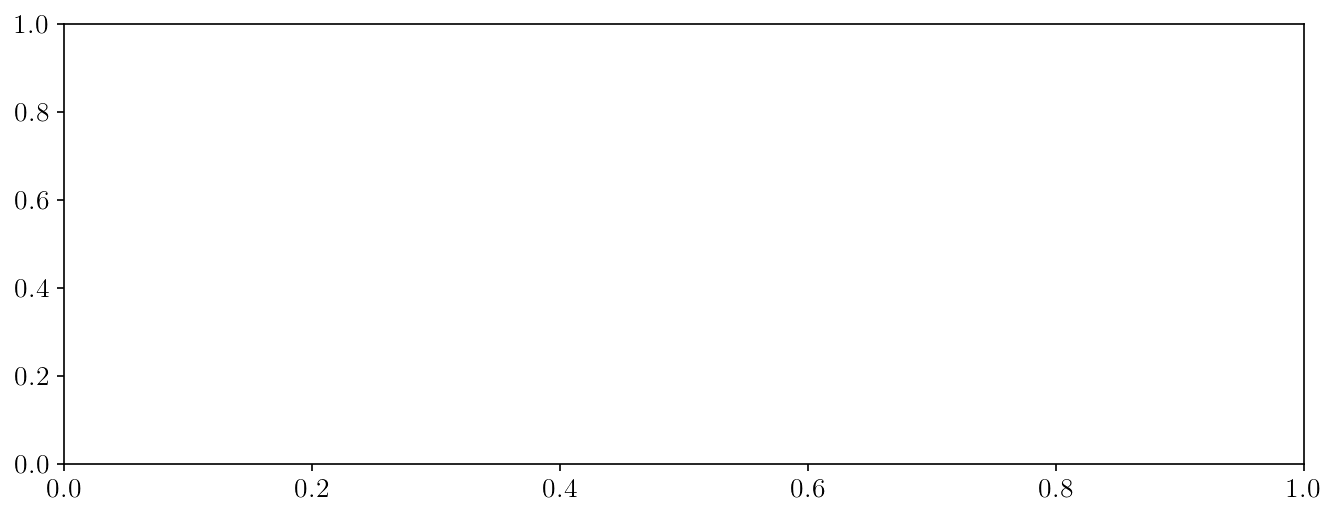

In [32]:
## This function iterates through the crossings, and makes and saves figures to be stitched into a movie.


save = True # if true save the figures to disk
conts = np.linspace(-3, 0, 50) # Contours of dye
rhoc = np.linspace(20, 30, 101)+0.1 # Contours of rho

fac = 1.5
plt.rcParams['font.size'] = 20/fac

norm = np.nanmax(fluorppb)

ckeeps = [4, 6, 8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22] # these are the crossings we keep (not all have good obs of dye)
ckeeps = range(0,82)
# Iterate through each crossing and make figure
for i in range(59,82, 1):
    print(i)
    fig = plt.figure(figsize=(16/fac,9/fac), dpi=fac*100)
    axdye = plt.subplot2grid((3,10), (0,0), rowspan = 2, colspan=10)

    span = range(II[ckeeps[i],0], II[ckeeps[i],1])
    span_ts = range(ii[ckeeps[i],0], ii[ckeeps[i],1])

    # Do all the projection work
    Xi, Yi, Ci, Ri, shiplogobs, depthobs = getProjectedSection(ckeeps[i])

    Xp = np.zeros(Xi.shape)
    Xp[:,1:] = 0.5*(Xi[:,1:] + Xi[:,0:-1]) # We are going to combine pcolor and contour, so need to shift the pcolor coordinates (which plots on vertices)
    Xp[:,0] = -6 # XXX- Check this for correctness
    
    cmap = 'gnuplot'
    
    # Plot the dye (finally)!
    im = axdye.pcolor(Xp, Yi, np.log10(Ci), vmin=conts[0], vmax=conts[-1], cmap=cmap)
    im.set_edgecolor('face')
    
    # Plot the Density
    cs = axdye.contour(Xi,Yi, Ri,rhoc, colors='w')
    axdye.clabel(cs, cs.levels[::2], inline=1, fontsize=10, fmt='%1.1f')
    
    # Format the figure
    axdye.set_ylim(0, 150)
    axdye.set_yticks([0, 50, 100, 150])
    axdye.invert_yaxis()
    axdye.set_xlabel('km')
    axdye.set_ylabel('Pressure [db]')
    mt = np.nanmean(jday[:,span])
    axdye.set_title(f'Days since dye release: {mt-64.87:3.2f}')
    axdye.set_xlim([-5, 5])
    
    # Plot the SST map
    axsst = plt.subplot2grid((3,10), (2,7), colspan=3)
    cmap = 'RdYlBu_r'
    tliml = 13
    tlimh = 23  
    aspratio = 1/np.cos(39*np.pi/180) # > 1 indicates x coordinate is smaller than y coordinate

    isst = axsst.pcolor(longrid[lonliml-1:lonlimr+1], latgrid[latliml-1:latlimr+1], np.transpose(sst[lonliml-1:lonlimr+1, latliml-1:latlimr+1]), cmap=cmap, vmin = tliml, vmax=tlimh)
    isst.set_edgecolor('face')
    indrelease = np.argmin(np.abs(fyds - 64.86))
    axsst.plot(flons[indrelease:], flats[indrelease:], linewidth=2,  color='k', label='Float')
    
    axsst.plot(flons[indrelease], flats[indrelease], marker='o', color='y')
    
    axsst.set_ylim(38.,39.5)
    axsst.set_xlim(-65.5, -62.5)
    axsst.set_aspect(aspratio)

    axsst.set_ylabel('Latitude', labelpad=-0.5)
    axsst.set_xlabel('Longitude')

           
    axsst.plot(lonK, latK, linewidth=2, color = '#1f77b4', label='R/V Knorr')
    l1, = axsst.plot(np.nanmean(lon[:,span], axis=0), np.nanmean(lat[:,span], axis=0), color = 'w', linestyle='dashed')
    l1.set_dashes([1, 1])
    
    axsst.legend(loc=4, ncol=2, fontsize=8, handletextpad=0.2, columnspacing=0.8)

    axflux = plt.subplot2grid((3,10), (2,0), colspan=7)
    
    # The original version had heat flux and wind stress magnitude, this is replaced (below) with a quiver plot
    #color = 'tab:blue'
    #axflux.plot(yearday, tmag, color=color, linewidth=2)
    #axflux.tick_params(axis='y', labelcolor=color)
    #axflux.set_ylabel('Wind-stress [N m$^{-2}$]', color=color)  # we already handled the x-label with ax1
    #axflux.set_ylim((0, 1.2))
    #axflux.set_yticks([0, 0.3, 0.6, 0.9,  1.2])
    #axflux.set_xlim((64.5, 66))
    #axflux.set_xlabel('yearday')
    
    #axflux2 = axflux.twinx()
#    axflux.axvline(time_f[i]/86400+64.5, linestyle='dashed', color='k')
#    axflux.axvline(np.nanmean(jday[:,span]), linestyle='dashed', color='k')
    #axflux.axvspan(np.nanmean(jday[:,span[0]]), np.nanmean(jday[:,span[-1]]), alpha=0.5)
    #color = 'tab:red'
    #axflux2.plot(yearday, qnet, color=color, linewidth=2)
    #axflux2.set_ylabel('Heat flux [W m$^{-2}$]', color=color)  # we already handled the x-label with ax1
    #axflux2.tick_params(axis='y', labelcolor=color)
    #axflux2.set_ylim((0, 1200))
    #axflux2.set_xlim((64.87, 66))
    #axflux2.set_yticks([0, 300, 600, 900,  1200])
    #axflux.grid(linestyle='dashed')
    
    #Quiver version here:
    color = 'tab:red'
    axflux.plot(yearday, qnet, color=color, linewidth=2)
    axflux.set_ylim(-0,1200)
    axflux.set_xlim(64.87, 66)
    axflux.grid(linestyle='dashed')
    axflux.set_ylabel('Heat flux [W m$^{-2}$]', color=color)  # we already handled the x-label with ax1
    axflux.tick_params(axis='y', labelcolor=color)
    axflux.set_xlabel('yearday')
    axflux.set_yticks([0, 600, 1200])
    axflux.axvspan(np.nanmean(jday[:,span[0]]), np.nanmean(jday[:,span[-1]]), alpha=0.5)
    #axflux.axvline(np.nanmean(jday[:,span]))
    axwind = axflux.twinx()
    axwind.set_yticklabels([])
    # Quiver plot of wind stress
    q = axwind.quiver(yearday, 600 + 0*yearday, tau_d, tau_cs, scale=10)

    # Add a legend for the quiver plot magnitude
    #axwind.quiverkey(q, 64.995, -1000, 0.5, 'Down-\nstream', coordinates='data', labelpos='S', fontproperties={'size': 10})
    #axwind.quiverkey(q, 64.94, -790, 0.5, 'Cross-\nstream', coordinates='data',labelpos='W', angle=90, labelsep=0.05, fontproperties={'size': 10})
    axwind.text(64.948, 850, '0.5\nN m$^{-2}$', fontsize=10, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
    axwind.quiver(64.935, 800, 0.5, 0., scale=10, width=3e-3)
    axwind.quiver(64.935, 800, 0., 0.5, scale=10, width=3e-3)
    axwind.text(64.88, 820, 'Cross-\nstream', fontsize=8, rotation=90)
    axwind.text(64.91, 700, 'Downstream', fontsize=8, rotation=0, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

    axwind.set_ylim(-0, 1200)
    
    # Do some adjusting to the figure itself
    plt.subplots_adjust(wspace=3.5, hspace=0.04)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.45, 0.01, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax, extend='min')
    cb.set_ticks([-3, -2, -1, 0])
    cb.set_label('log$_{10}$[Normalized Concentration]')
    
    cbaxes = inset_axes(axsst, width="40%", height="3%", loc=9) 
    cb = plt.colorbar(isst, cax=cbaxes, orientation='horizontal', extend='both')
    cb.set_label('SST [$^{\circ}$ C]', color='w', fontsize=10, labelpad=-1)
    cb.outline.set_edgecolor('w')
    cb.set_ticks([tliml, (tlimh-tliml)/2+tliml, tlimh])
    cb.ax.xaxis.set_tick_params(color='w')
    cb.ax.tick_params(labelsize=8)
    plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w') # set colorbar  
    fig.tight_layout(pad=0.2)
    fig.subplots_adjust(right=0.9, wspace=5)
    if save:
        plt.savefig(f'/data/pacific/jacob/LATMIXDYE/ObsMovieFigs/LatmixDyeObs_{i}.png')
        plt.close('all')
    
## TO MAKE MOVIE RUN THIS SCRIPT IN COMMAND LINE
# ffmpeg -start_number 0 -i LatmixDyeObs_%d.png -pix_fmt yuv420p -vf "setpts=48*PTS" dye_obs.mov

## EXTRAS
Below are a variety of additional code snippets used in testing. 


In [20]:
range(0,50)[1]

1

In [127]:
np.max(tmag)

1.181446135909563

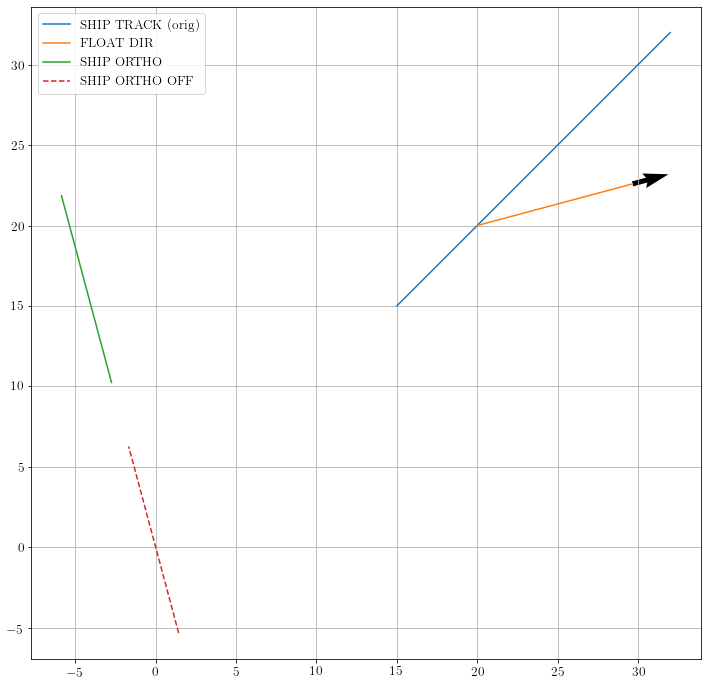

In [256]:
testoff= 20
x, y = (np.array((-5+testoff,12+testoff)), np.array((-5+testoff,12+testoff)))
#x, y = (np.array((-5,12)), np.array((5,-12)))
theta = np.pi/12
fl = 1e1
fx, fy = (fl*np.cos(theta)+testoff, fl*np.sin(theta)+testoff)
#fx = fx-np.mean(x); fy = fy-np.mean(y)
#x = x-np.mean(x); y = y-np.mean(y)

ang = np.arctan2(y, x)
plt.figure(figsize=(12,12))
plt.plot(x, y, label='SHIP TRACK (orig)')
meanx = np.mean(fx); meany= np.mean(fy)
#x = x-fx; y = y-fy; fx = 0; fy=0
#y = y-meany; x= x- meanx; 
#plt.plot(x, y, label='SHIP TRACK (adjusted)')
plt.plot((fx-fl*np.cos(theta), fx), (fy-fl*np.sin(theta), fy), label='FLOAT DIR')
plt.grid()
plt.axis('equal')


# Rotate coordinate system into along-float direction (x), and across-float direction (y)

rotatedpoints = (x*np.cos(theta)+y*np.sin(theta), -x*np.sin(theta)+y*np.cos(theta))

ang = np.arctan2(y, x)
angdiff = ang-theta

offsetlength = np.sqrt(fx**2+fy**2)*np.cos(angdiff)
offsetx = offsetlength*np.cos(ang); offsety = offsetlength*np.sin(ang)
rotatedoff = (offsetx*np.cos(theta)+offsety*np.sin(theta), -offsetx*np.sin(theta)+offsety*np.cos(theta))


fxo, fyo = (np.cos(theta+np.pi/2), np.sin(theta+np.pi/2))

#plt.plot( rotatedpoints[0]*np.cos(theta),  rotatedpoints[0]*np.sin(theta), label='SHIP ALONG', linestyle='--')
plt.plot(rotatedpointsts[1]*fxo,  rotatedpoints[1]*fyo, label='SHIP ORTHO')
plt.plot((rotatedpoints[1]-rotatedoff[1])*fxo,  (rotatedpoints[1]-rotatedoff[1])*fyo, label='SHIP ORTHO OFF', linestyle='--')
plt.quiver(fx, fy, np.cos(theta), np.sin(theta))
plt.legend()


Maximum float: 3.3301270189221936
[ 7.06217783  6.91131446  6.7604511   6.60958773  6.45872437  6.30786101
  6.15699764  6.00613428  5.85527091  5.70440755  5.55354418  5.40268082
  5.25181746  5.10095409  4.95009073  4.79922736  4.648364    4.49750064
  4.34663727  4.19577391  4.04491054  3.89404718  3.74318381  3.59232045
  3.44145709  3.29059372  3.13973036  2.98886699  2.83800363  2.68714026
  2.5362769   2.38541354  2.23455017  2.08368681  1.93282344  1.78196008
  1.63109672  1.48023335  1.32936999  1.17850662  1.02764326  0.87677989
  0.72591653  0.57505317  0.4241898   0.27332644  0.12246307 -0.02840029
 -0.17926365 -0.33012702]


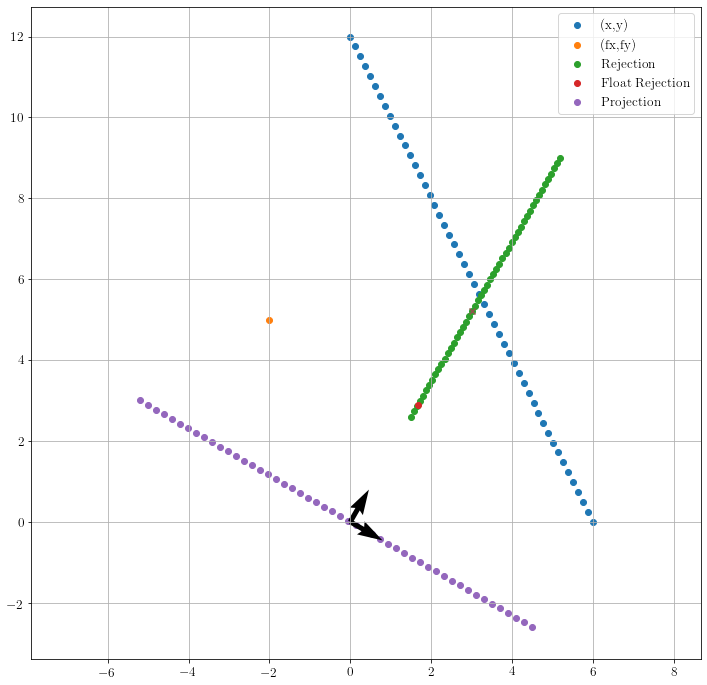

In [495]:

def projection(x,y,theta):
    on = np.array([np.cos(theta), np.sin(theta)]) # unit vector of direction
    pj = (np.dot(np.array([x,y]).T, on)*on[:,np.newaxis])
    return pj

def rejection(x,y,theta):
    pj = projection(x,y,theta)
    return np.array([x,y]) - pj



testoff = -0
x, y = (np.array((-5+testoff,12+testoff)), np.array((-5+testoff,12+testoff)))
x = np.linspace(0,6) + testoff; y = np.linspace(12,0)+testoff
#x, y = (np.array((-5,12)), np.array((5,-12)))
theta = -np.pi/6
#fl = 20
#fx, fy = (fl*np.cos(theta)+testoff, fl*np.sin(theta)+testoff)
fx = -2+testoff; fy = 5+testoff
plt.figure(figsize=(12,12))
plt.scatter(x,y, label='(x,y)')
plt.scatter(fx, fy, label='(fx,fy)')
fang = np.arctan2(y,x)
fxv = np.cos(theta); fyv = np.sin(theta)
#rj = rejection(np.array([x,y]).T, np.tile(np.array([fxv,fyv]), (50,1)).T)
#pj = projectAngle(x, y, theta)
#rj = rejectangle(x, y, theta)
on = np.array([np.cos(theta), np.sin(theta)])
pj = projection(x,y, theta)
rj = rejection(x,y,theta)

fj = rejection(np.array([fx]),np.array([fy]), theta)

#pj = projection(np.array([x,y]), np.array([fxv,fyv]))
plt.scatter(rj[0], rj[1], label='Rejection')
plt.scatter(fj[0], fj[1], label='Float Rejection')
plt.scatter(pj[0], pj[1], label='Projection')
#plt.scatter(rj[0] - fj[0], rj[1]-fj[1], label='Projection FLOAT NORM')

#rj = rejection(x-fx,y-fy,theta)
#plt.scatter(rj[0], rj[1])
plt.quiver(0,0, fxv, fyv)
#plt.ylim(-12, 20)
#plt.xlim(-12, 20)
plt.grid()
#print(pj)
plt.axis('equal')
plt.legend()

def projecDims(x,y,fx, fy, theta):
    on = np.array([np.cos(theta), np.sin(theta)]) #vector of float DIRECTION (diff from position)
    pj = projection(x,y, theta)
    rj = rejection(x,y,theta)
    fj = rejection(np.array([fx]),np.array([fy]), theta)
    
    
    distrej = np.dot(rj.T, np.array([-np.sin(theta), np.cos(theta)]))
    distfloat = np.dot(fj.T, np.array([-np.sin(theta), np.cos(theta)]))
    return distrej-distfloat
plt.scatter(rj[0][ind], rj[1][ind], marker='x')
plt.quiver(0,0, -np.sin(theta), np.cos(theta))
fjdist = np.sqrt(fj[0]**2 + fj[1]**2)


print(f'Maximum float: {np.min(fjdist)}')
print(projecDims(x,y,fx,fy, theta))
#orthocoord = rjdist - fjdist
orthocoord = projecDims(x,y,fx,fy, theta)
#print(orthocoord)

In [474]:
distrej - distfloat



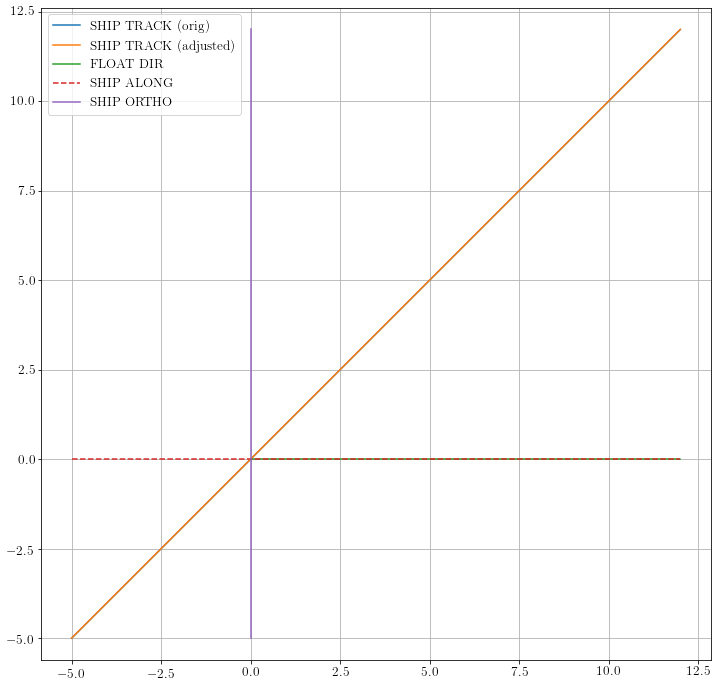

In [401]:
x, y = (np.array((-5,12)), np.array((-5,12)))

theta = -np.pi/12*0
fl = 12
fx, fy = (fl*np.cos(theta), fl*np.sin(theta))
ang = np.arctan2(y, x)

angdiff = ang-theta

projection_mag = np.sqrt(x**2 + y**2)*np.cos(angdiff)
xr = x - projection_mag*np.cos(theta)
yr = y - projection_mag*np.sin(theta)
rejection_mag = np.sqrt(xr**2 + yr**2)

plt.figure(figsize=(12,12))
plt.plot(x, y, label='SHIP TRACK (orig)')
plt.plot(x, y, label='SHIP TRACK (adjusted)')
plt.plot((0, fx), (0, fy), label='FLOAT DIR')
plt.grid()
plt.axis('equal')


# Rotate coordinate system into along-float direction (x), and across-float direction (y)
rotatedpoints = (x*np.cos(theta)+y*np.sin(theta), -x*np.sin(theta)+y*np.cos(theta))
#rotatedpoints = (x*np.cos(ang-theta)+y)
fxo, fyo = (np.cos(theta+np.pi/2), np.sin(theta+np.pi/2))

plt.plot( rotatedpoints[0]*np.cos(theta),  rotatedpoints[0]*np.sin(theta), label='SHIP ALONG', linestyle='--')
plt.plot(rotatedpoints[1]*fxo,  rotatedpoints[1]*fyo, label='SHIP ORTHO')

plt.legend()


In [157]:
print('Minimum y: ' + str(np.sin(theta)*5))
print('minimum y projected: ' + str((rotatedpoints[0])))

Minimum y: 5.0
minimum y projected: [-5.  7.]


In [196]:
np.mean(fy)

-3.105828541230249

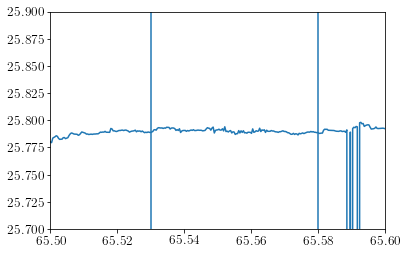

In [113]:
m = Rf>0
#plt.plot(fydr[m], fP[m])
plt.plot(fydr[m], Rf[m])
plt.ylim(25.7, 25.9)
plt.xlim(65.5, 65.6)
plt.axvline(65.53)
plt.axvline(65.58)

(65.5, 65.6)

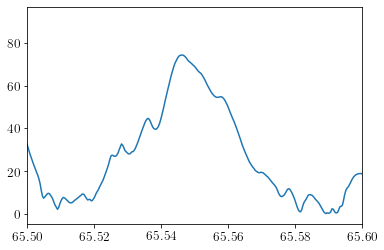

In [115]:
plt.plot(fydr, fP)
plt.xlim(65.5, 65.6)

In [227]:
### OLD VERSION OF PROJECTION ###


# Projection routine for taking a lat, lon coordinate, and projecting it into the coordinate normal to the float direction
# By default this uses epsg:26920 (zone 20 UTM), but can also send other projections
# Naive projection is just to directly convert to meters (projection='naive')

import pyproj as proj

def projectCoords(lat, lon, flat, flon, projection='epsg:26920'):
    print(f"Projection type: {projection}")
    if projection == 'naive': # Directly convert to meters
        y = (lat)*111e3 
        x = (lon*np.cos(lat*np.pi/180))*111e3
        fy = flat*111e3
        fx = flon*111e3*np.cos(flat*np.pi/180)
    elif projection=='local':
        crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic
        #Erect own local flat cartesian coordinate system around mean lat/lon
        cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(np.nanmean(lat), np.nanmean(lon)))
        x, y = proj.transform(crs_wgs, cust, lon, lat)
        fx, fy = proj.transform(crs_wgs, cust, flon, flat)
    else: # Use a UTM projection
        transformer = proj.Transformer.from_crs('epsg:4326', projection, always_xy=True)
        x, y = transformer.transform(lon, lat)
        fx, fy = transformer.transform(flon, flat)

    fxv = np.gradient(fx)/np.gradient(fyds*86400) # Calculate float velocity
    fyv = np.gradient(fy)/np.gradient(fyds*86400)
    fxvm = (np.interp(np.nanmean(jday[:,span]), fyds, fxv)) # Interpolate float velocity to the mean section time
    fyvm = (np.interp(np.nanmean(jday[:,span]), fyds, fyv))
    fang = np.arctan2(fyvm, fxvm) # Get the angle of the mean float velocity
    theta = fang
    print(fang)
    #print(theta)
    meanfloaty = np.interp(np.nanmean(jday[:,span]), fyds, fy) # What is the float lat during the survey average?
    meanfloatx = np.interp(np.nanmean(jday[:,span]), fyds, fx) # What is the float lon during the survey average?
    #Reference x-y to the float location (ie. float is at 0,0)
    #x = x - meanfloatx; y = y - meanfloaty
    
    # Rotate coordinate system into along-float direction (x), and across-float direction (y)
    rotatedpoints = (x*np.cos(theta)+y*np.sin(theta), -x*np.sin(theta)+y*np.cos(theta))
    
    ang = np.arctan2(y, x)
    angdiff = ang-theta
    offsetlength = np.sqrt(meanfloatx**2+meanfloaty**2)*np.cos(angdiff)
    offsetx = offsetlength*np.cos(ang); offsety = offsetlength*np.sin(ang)
    rotatedoff = (offsetx*np.cos(theta)+offsety*np.sin(theta), -offsetx*np.sin(theta)+offsety*np.cos(theta))
    
    rx = rotatedpoints[0] - rotatedoff[0]; ry = rotatedpoints[1]-rotatedoff[1]
    return rx/1000, ry/1000

In [43]:
tmag.shape
yearday.shape

mask = (yearday>64.87)&(yearday<65.5)
print(f'Mean Tau: {np.mean(tmag[mask])}')
print(f'Iso turbulence scaling: {np.mean(np.sqrt(tmag[mask]/1035)*75)}')
print(f'Mean us = {np.mean(np.sqrt(tmag[mask]/1035))}')

Mean Tau: 0.4411312325909237
Iso turbulence scaling: 1.3371418511233464
Mean us = 0.017828558014977954


In [38]:
2*2*np.pi/86400*np.sin(38*np.pi/180)

8.954433185098802e-05